<a href="https://colab.research.google.com/drive/1Xbx2His-wm_2TQqGeeARoocS38ERLzGw?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning SP 2022/2023

- Prof. Cesare Alippi
- Giorgia Adorni ([`giorgia.adorni@usi.ch`](mailto:giorgia.adorni@usi.ch))<br>
- Fatima Ezzeddine ([`fatima.ezzeddine@usi.ch`](mailto:fatima.ezzeddine@usi.ch))<br>
- Alessandro Manenti ([`alessandro.manenti@usi.ch`](mailto:alessandro.manenti@usi.ch))

---
# Lab 04: Feedforward Neural networks


Also known as __multilayer perceptrons__ , neural networks are computational models inspired by the connected structure of the brain. The core component of neural networks is the neuron, which is composed of a perceptron and an activation function: 

$$
f(x; \boldsymbol \theta) =  h( x^T \boldsymbol \theta).
$$

The main idea behind neural networks is to compose neurons in two different ways: 

1. by taking many neurons __in parallel__;
2. by composing many subsequent __layers__ of neurons;

The result is a network of neurons that take data as input, and compute sequential transformations until the desired result is produced as output.

![alt text](https://res.cloudinary.com/practicaldev/image/fetch/s--4XiAvCCB--/c_limit%2Cf_auto%2Cfl_progressive%2Cq_auto%2Cw_880/https://cdn-images-1.medium.com/max/1200/1%2AYgJ6SYO7byjfCmt5uV0PmA.png)

---

We can write the output of the hidden layer as:

$$
\begin{bmatrix} 
h_0 \\
h_1 \\
h_2 \\
\vdots\\
h_l 
\end{bmatrix}
=
h\left(
\begin{bmatrix} 
w_{00} & w_{01} & w_{02} & \cdots & w_{0m} \\
w_{10} & w_{11} & w_{12} & \cdots & w_{1m} \\
w_{20} & w_{21} & w_{22} & \cdots & w_{2m} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
w_{l0} & w_{l1} & w_{l2} & \cdots & w_{lm} \\
\end{bmatrix}
\begin{bmatrix} 
x_0 \\
x_1 \\
x_2 \\
\vdots\\
x_m
\end{bmatrix}
+
\begin{bmatrix} 
b_0 \\
b_1 \\
b_2 \\
\vdots\\
b_l
\end{bmatrix}
\right)
$$

In short, we write the output of a __layer__ of neurons as:
$$
H = h(Wx + b_w)
$$

_NB: without the activation function a layer is a simple affine trasformation._

We can compute the output of the network doing the same calculation for the  "Output" neurons, with the difference that their input is not $X$, as for the hidden neurons, but it is the output $H$ of the last hidden layer. The output layer can be written as: 

$$
Y = \sigma(VH + b_v)
$$

(note that $V$ is a different matrix of parameters).

Finally, stacking the two layers simply means __composing__ them together, so that the whole neural network can be written as: 

$$
\hat y = f(x;\boldsymbol \theta = \{W, b_w, V, b_v\}) = \sigma\left(V h(Wx + b_w)  + b_v\right)
$$

---
Neural networks are trained with __stochastic gradient descent__ (SGD). The key idea behind SGD is to update all the parameters of the network at the same time, based on how each parameter contributed to the __loss__ function $L( \boldsymbol \theta)$. 

The generalized update rule reads: 

$$
{\boldsymbol \theta}^{i+1} = {\boldsymbol \theta}^{i} - \varepsilon \frac{\partial L({\boldsymbol \theta})}{\partial {\boldsymbol \theta}}\bigg\vert_{{\boldsymbol \theta} = {\boldsymbol \theta}^i}
$$

where $\varepsilon$ is again called __learning rate__.

---

When training neural networks for binary classification, we take the loss to be the __cross-entropy error function__: 

$$
L({\boldsymbol \theta}) =  -\frac1n \sum_{i=1}^n \bigg[y_i  \log \hat y_i + (1 - y_i)  \log (1 - \hat y_i)\bigg]
$$


# Neural networks in Python

To build our neural network we will use [TensorFlow](https://www.tensorflow.org/), one of the most popular deep learning libraries for Python (the other being [PyTorch](https://pytorch.org/)). 
TensorFlow provides a huge number of functions, like Numpy, that can be used to manipulate arrays, but offers two great advantages w.r.t. Numpy: 

1. the computation can be accelerated on GPU via the CUDA library;
2. the library implements __automatic differentiation__, meaning that the most analytically complex step of training, the computation of the gradient, is handled for you.

While TensorFlow is a very powerful library that offers a fine-coarsened control over what you build, for this course we will skip the low level details and instead use the official high-level API for TensorFlow: [Keras](https://keras.io).

## Introduction to Keras

![alt text](https://s3.amazonaws.com/keras.io/img/keras-logo-2018-large-1200.png)



Keras offers collections of TF operations already arranged to implement neural networks with little to no effort. 
For instance, building a layer of 4 neurons like the one we saw above is as easy as calling `Dense(4)`. That's it. 

Moreover, Keras offers a high-level API for doing all the usual steps that we usually do when training a neural network, like training on some data, evaluating the performance, and predicting on unseen data. 

The core data structure of Keras is a model, a way to organize layers. The simplest type of model is the `Sequential` model, a linear stack of layers.

---

Let's start with a toy classification problem.

In [ ]:
import numpy as np
from sklearn.datasets import make_classification, make_circles, make_moons
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# color_maps
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF']) 

# function to generate classification problems
def get_data(n, ctype='simple'):
  if ctype == 'simple':
    x, y = make_classification(n_features=2, 
                               n_redundant=0, 
                               n_informative=2, 
                               n_clusters_per_class=1)
    x += np.random.uniform(size=x.shape) # add some noise
  elif ctype == 'circles':
    x, y = make_circles(n, noise=0.1, factor=0.5)
  
  elif ctype == 'moons':
    x, y = make_moons(n, noise=0.1)
  else:
    raise ValueError
  return x, y.reshape(-1, 1)

# function to plot decision boundaries
def plot_decision_surface(model, x, y, transform=lambda x:x):    
  #init figure
  fig = plt.figure()

  # Create mesh
  h = .01  # step size in the mesh
  x_min, x_max = x[:, 0].min() - .5, x[:, 0].max() + .5
  y_min, y_max = x[:, 1].min() - .5, x[:, 1].max() + .5
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))

  # plot train data
  plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright,
              edgecolors='k')
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

  plt.xlabel(r'$x_1$')
  plt.ylabel(r'$x_2$');

  y_pred = model.predict(transform(np.c_[xx.ravel(), yy.ravel()]))

  y_pred = y_pred.reshape(xx.shape)
  plt.contourf(xx, yy, y_pred > 0.5, cmap=cm, alpha=.5)

Let's go back to the problem that we saw in the previous part.

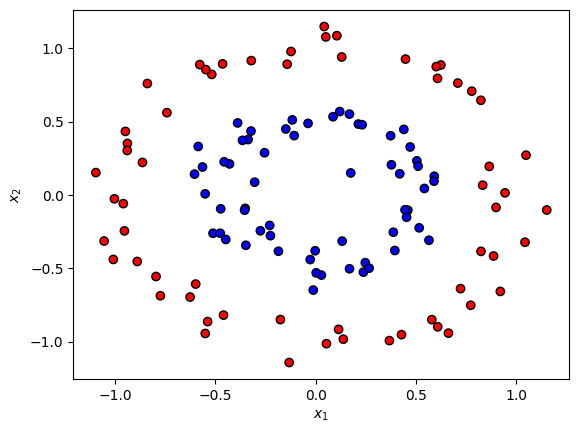

In [ ]:
np.random.seed(20)

# Create a classification problem
x, y = get_data(120, 'circles')

# Let's look at the data
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright, edgecolors='k')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$');

Now let's build a neural network to fit the data.

Using Keras, this will take only a few lines of code.

2023-04-05 16:07:06.330270: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-05 16:07:06.355824: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-05 16:07:06.732411: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-05 16:07:07.117695: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.

3362/3362 [==============================] - 1s 315us/step


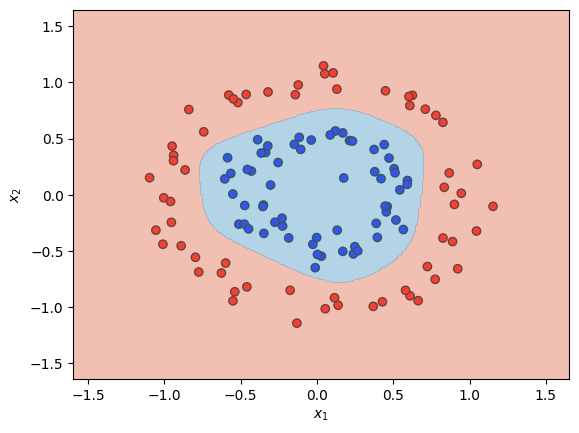

In [ ]:
from keras import Input, Model
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from tensorflow import keras
from keras.callbacks import EarlyStopping
import tensorflow as tf

tf.random.set_seed(25) # this makes the experiment easy to reproduce

# Define the network
classifier = Sequential()
classifier.add(Dense(8, activation='tanh', input_shape=(x.shape[1],)))
classifier.add(Dense(1, activation='sigmoid'))

# Set up the model for training
classifier.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.025), # choose optimizer and learning rate
                   loss=losses.BinaryCrossentropy(),                        # define loss function 
                   metrics=['accuracy']                                     # define metric to monitor during training
                  )

# Evaluate the performance
classifier.fit(x, y, epochs=100, verbose=0)
plot_decision_surface(classifier, x, y)

Let's try to understand why this is working adding another hidden layer with 2 units to visualize the space in which a neural network projects the data.

In [ ]:
def compute_boundary(out_layer):
  w = np.asarray(out_layer.weights[0]).ravel()
  b = np.asarray(out_layer.bias).ravel()
  theta = np.r_[b, w].ravel()
  b = -theta[0]/theta[2]
  m = -theta[1]/theta[2]

  x1 = np.array([x[:,0].min(), x[:,0].max()])
  x2 = b + m * x1
  return x1, x2



def plot_training_iterations(classifier, features, out_layer, iterations=200):
  from IPython import display

  phi = features.predict(x)
  xd, yd = compute_boundary(out_layer)


  #init figure
  fig = plt.figure()
  ax = fig.gca()
  #fixed plots
  ax.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright, edgecolors='k', alpha=0.05)
  splt = ax.scatter(phi[:, 0], phi[:, 1], c=y, cmap=cm_bright, edgecolors='k')
  line = ax.plot(xd, yd, color='black')[0]
  ax.set_xlabel(r'$\phi_1$')
  ax.set_ylabel(r'$\phi_2$')
  ax.set_xlim([-1.3, 1.3])
  ax.set_ylim([-1.3, 1.3])
  display.display(plt.gcf(), display_id=40)

  n = iterations
  e = 10
  for i in range(n):
    hist = classifier.fit(x, y, epochs=e, verbose=0)
    phi = features.predict(x)
    _, yd = compute_boundary(out_layer)
    ax.set_title(f"Iteration {(i+1)*e}/{e*n} | Train accuracy: {hist.history['accuracy'][-1]:.2f}")
    # update plot
    splt.set_offsets(phi)
    line.set_ydata(yd)
    display.clear_output(wait=True)
    #display.update_display(plt.gcf(), display_id=40)
    display.display(plt.gcf(), display_id=40)

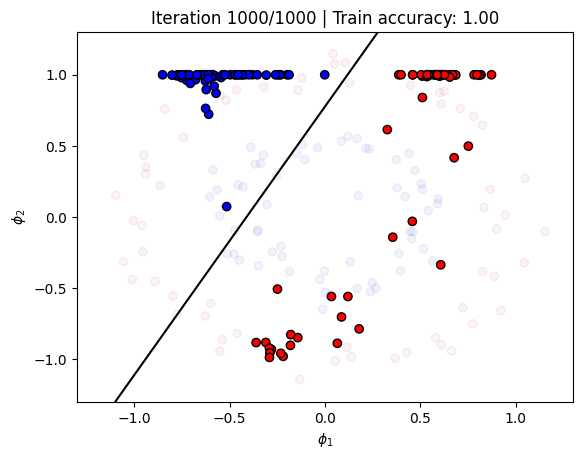

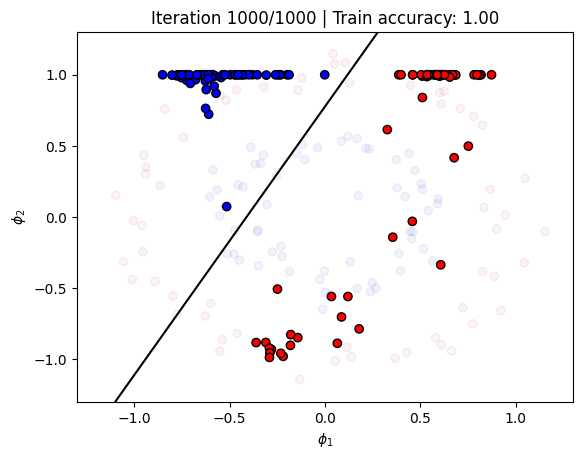

In [ ]:
tf.random.set_seed(25)
# An alternative way to define a network in keras as a sequence of operations

inp = Input((x.shape[1],)) # inpute layer
hidden1 = Dense(8, activation='tanh')(inp) # first nonlinear transormation
hidden2 = Dense(2, activation='tanh')(hidden1) # second nonlinear transformation

out_layer = Dense(1, activation='sigmoid')
out = out_layer(hidden2) # output layer

# define the model using the input and output layers
classifier = Model(inp, out)
classifier.compile(loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

features = Model(inp, hidden2)

plot_training_iterations(classifier, features, out_layer, iterations=100);

The data are linearly separable in the projected space!

If you go back and remove the nonlinear activation functions from the hidden layers, you'll see that this is not true anymore. In fact, without nonlinearities the hidden layers are simple affine transormations (e.g., can represent only linear mappings like rotation, translation, shear, ...).

_Homework: check [this](https://colah.github.io/posts/2014-03-NN-Manifolds-Topology/) insightful blog post from Chris Olah._

4/4 [==============================] - 0s 1ms/step


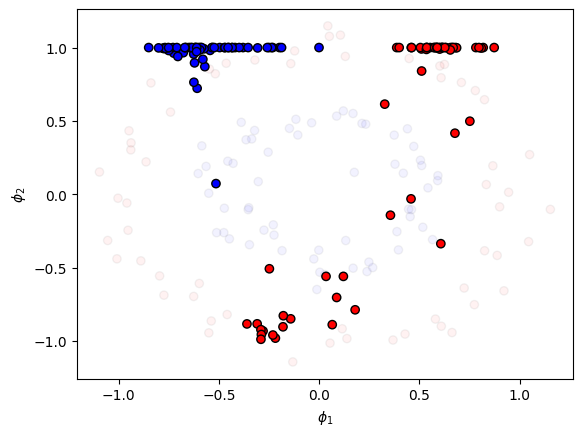

In [ ]:
features = Model(inp, hidden2)
phi = features.predict(x)

plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright, edgecolors='k', alpha=0.05)
plt.scatter(phi[:, 0], phi[:, 1], c=y, cmap=cm_bright, edgecolors='k')
plt.xlabel(r'$\phi_1$')
plt.ylabel(r'$\phi_2$');

# Wine quality dataset

Let's try with a real dataset now. 

We are given a set of wine reviews, with the following characteristics: 

In [ ]:
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(url, delimiter=';')

data.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5


<Axes: >

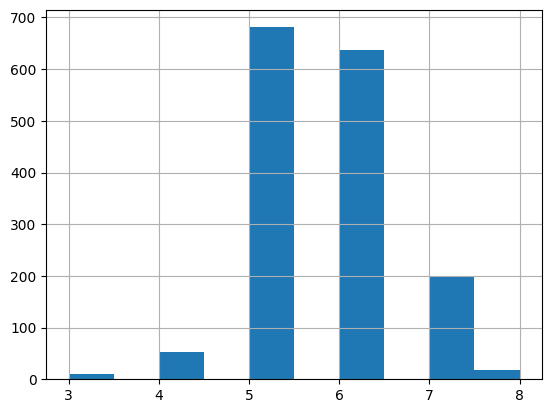

In [ ]:
# Let's look at the distribution of the reviews
data['quality'].hist(bins=10)

We can turn this into a binary classification problem by setting a threshold on the reviews: was the wine good (>= 6) or not?

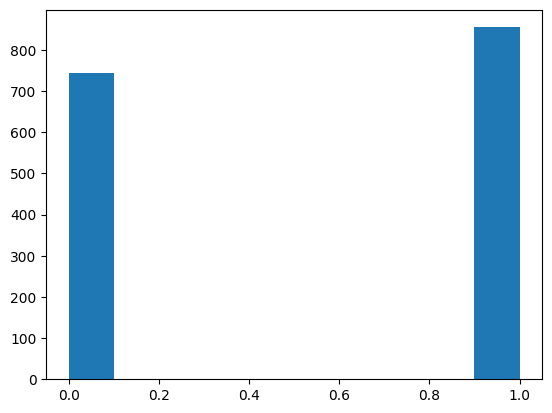

In [ ]:
# Extract features
X = data[data.columns[:-1]].values

# Extact targets
quality = data['quality'].values.astype(np.int32)
y = (quality >= 6).astype(np.int32)
plt.hist(y);

Notice how the values of the features are not commensurable with one another. For instance, "total sulfur dioxide" can have values up to 100, while the "density" is necessarily limited to be <= 1. 

While this in principle is not a problem for our machine learning models, in practice it can lead to issues in the training procedure.

To standardize the data, we compute the following transformation: 

$$
X_{\textrm{standardized}} = \frac{X - \textrm{mean}(X)}{\textrm{std}(X)}
$$

NB: here we are scaling the complete dataset at once for semplicity, but in reality you should use only training data to compute mean and std deviation. Do it in the proper way in the assignments :D

In [ ]:
# Normalize features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

In order to train our network, we will split the data into train and test set:

In [ ]:
from sklearn.model_selection import train_test_split

# Split train / test / validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

Let's also implement early stopping

<div style="text-align:center;">
    <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*nhmPdWSGh3ziatQKOmVq0Q.png" width="50%">
</div>

Now that we have loaded and pre-processed our data, we only need to build the neural network that we will train. 

In [ ]:
# Define the network
network = Sequential()
network.add(Dense(32, activation='relu', input_shape=X.shape[1:]))
network.add(Dense(1, activation='sigmoid'))

# Prepare the computational graph and training operations
network.compile(optimizer='sgd', 
                loss='binary_crossentropy', 
                metrics=['acc'])

# we would seek a minimum for validation loss, whereas we would seek a maximum for validation accuracy
es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose= 1)

# Train the network
history = network.fit(X_train, y_train, epochs=1000, callbacks = [es], validation_data=(X_val, y_val))

# Evaluate the performance
eval_results = network.evaluate(X_test, y_test)
print('Test loss: {} - Test acc: {}'.format(*eval_results))

Epoch 1/1000
41/41 [==============================] - 0s 3ms/step - loss: 0.7259 - acc: 0.4695 - val_loss: 0.7264 - val_acc: 0.4583
Epoch 2/1000
41/41 [==============================] - 0s 931us/step - loss: 0.6795 - acc: 0.5444 - val_loss: 0.6978 - val_acc: 0.5417
Epoch 3/1000
41/41 [==============================] - 0s 1ms/step - loss: 0.6488 - acc: 0.6069 - val_loss: 0.6775 - val_acc: 0.5625
Epoch 4/1000
41/41 [==============================] - 0s 925us/step - loss: 0.6266 - acc: 0.6610 - val_loss: 0.6618 - val_acc: 0.6042
Epoch 5/1000
41/41 [==============================] - 0s 959us/step - loss: 0.6097 - acc: 0.6803 - val_loss: 0.6485 - val_acc: 0.6389
Epoch 6/1000
41/41 [==============================] - 0s 941us/step - loss: 0.5958 - acc: 0.6927 - val_loss: 0.6374 - val_acc: 0.6458
Epoch 7/1000
41/41 [==============================] - 0s 869us/step - loss: 0.5846 - acc: 0.7058 - val_loss: 0.6280 - val_acc: 0.6458
Epoch 8/1000
41/41 [==============================] - 0s 970us/ste

plotting the training and validation loss function

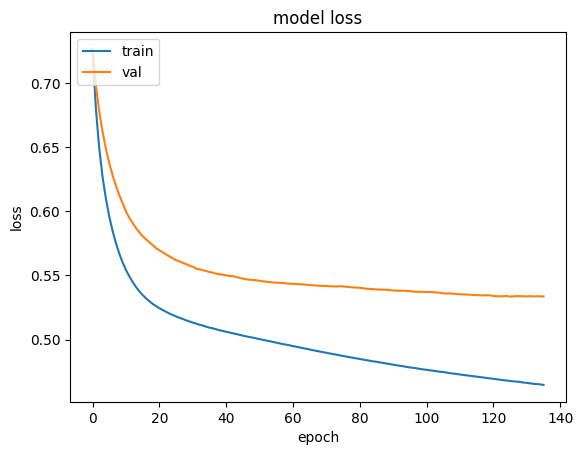

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Pokémon dataset: unbalanced classes

Pokémon are fictional creatures that are central to the Pokémon franchise.
Among them, Legendary Pokémon are a group of incredibly rare and often very powerful Pokémon, generally featured prominently in the legends and myths of the Pokémon world [[source]](https://bulbapedia.bulbagarden.net/wiki/Legendary_Pok%C3%A9mon).

The task that we will tackle in this exercise is simple: can we tell whether a Pokémon is legendary or not, by looking at its statistics (like attack, defense, HP, etc.)?

Let's start by getting the data and looking at it...

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import losses
from tensorflow import keras
import tensorflow as tf


url = 'https://raw.githubusercontent.com/lgreski/pokemonData/565a330aa57d1f60e1cab9d40320cf7473be566c/Pokemon.csv'
data = pd.read_csv(url)

data.head(10)

We will train a neural network to predict the "Legendary" labels using 'HP', 'Attack', 'Defense', 'SpecialAtk', 'SpecialDef', and 'Speed' as features.

In [ ]:
# Extract features
X = data[['HP', 'Attack', 'Defense', 'SpecialAtk', 'SpecialDef', 'Speed']].values

# Extact targets
y = data['Legendary'].values.astype(np.float32)

Like we did before, we will need to standardize the data in order to have commensurable features.

In [ ]:
# Standardize data
X = (X - X.mean(0)) / X.std(0)
print(X)



However, here we face a problem that we didn't have before: we have substantially less samples of one class w.r.t. the other. This means that our neural network is likely to ignore samples with $y=1$, because getting right the samples for which $y=0$ will lead to a lower error. 

Would you study for an exam question that was only asked once by the professor, in previous years? Or would you focus on the more common exercises that are more likely to be asked again? :)


In [ ]:
# Plot histogram of labels
plt.hist(y)
plt.title("Histogram of labels")
plt.xlabel("Class")
plt.ylabel("Numer of samples in class y")
plt.show()

To deal with the __class unbalance__ we will use a simple trick, that will allow our model to learn better. 

The trick consists in __re-weighting__ the loss function, so that the error on rare samples will count more than the error on common samples:

$$
L_{\textrm{reweighted}}(y, f(X; W)) =
\begin{cases}
\lambda_0 L(y, f(X; W))\textrm{, if } y=0 \\
\lambda_1 L(y, f(X; W))\textrm{, if } y=1
\end{cases}
$$

Ideally, $\lambda_0$ and $\lambda_1$ should represent how rare the respective classes are in the dataset. 
A common way of computing the two values automatically is as: 

$$
\lambda_i = \frac{\textrm{\# samples in dataset}}{\textrm{\# classes}\cdot\textrm{\# samples of class } i}
$$

In Keras (and also in Scikit-learn) we call these values `class_weight`.

Let's see how to compute them...

In [ ]:
# Split train / test / validation data
np.random.seed(0)

X_train, X_not_train, y_train, y_not_train = train_test_split(X, y, train_size=0.8, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_not_train, y_not_train, test_size=0.5, stratify=y_not_train)

# Compute class weights
n_pokemons = X_train.shape[0]
n_legendaries = y_train.sum()
n_classes = 2
class_weights = {0: n_pokemons / (n_classes * (n_pokemons - n_legendaries)),
                 1: n_pokemons / (n_classes * n_legendaries)}

print('Training data: {} legendaries out of {} pokemons'.format(int(n_legendaries), int(n_pokemons)))
print('Training data: class weights {}'.format(class_weights))

In order to train a neural network in Keras using class weights, we only need to apport some minor modifications to the previous model:

In [ ]:
keras.utils.set_random_seed(0)

network = Sequential()
network.add(Dense(32, activation='relu', input_shape=X.shape[1:]))
network.add(Dense(1, activation='sigmoid'))

network.compile('sgd', 'binary_crossentropy', weighted_metrics=['acc'])

network.fit(X, y, epochs=100, validation_data=(X_val, y_val))

# network.fit(X, y, epochs=100, validation_data=(X_val, y_val), class_weight=class_weights)

Finally, let's analyze the __test__ performance of our model:

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes=["Normal", "Legendary"]):
    cm = confusion_matrix(y_true, y_pred)
    fig = sns.heatmap(cm, annot=True, xticklabels=classes,
                      yticklabels=classes, cmap=plt.cm.Oranges)
    fig.set_xlabel("Predicted label")
    fig.set_ylabel("True label")
    fig.set_title("Test confusion matrix")


test_results = network.evaluate(X_test, y_test, verbose=False)
print('Loss: {:.4f} - Accuracy: {:.2f}'.format(*test_results))

y_pred = network.predict(X_test)
y_pred = np.round(y_pred)

plot_confusion_matrix(y_test, y_pred)
